# Курс Спортивный анализ данных. Платформа Kaggle

# Практическое задание урока 3. Построение надежных схем валидации решения, оптимизация целевых метрик

**Основное задание:**

* Даны выборки для обучения и для тестирования. 
* Задание заключается в том, чтобы попробовать разные способы валидации, проанализировать плюсы / минусы каждой и сделать выводы о том, какой способ валидации наиболее устойчивый в данной задаче. 
* Метрика качества для оценки прогнозов - ROC-AUC, название целевой переменной - IsFraud. Рекомендуется использовать модели градиетного бустинга, реализация любая / гипепараметры любые. 

***Внимание!*** выборка assignment_2_test.csv - наш аналог лидерборда. Будем моделировать ситуацию отправки решения на лидерборд и сравнить значение метрики на лидерборде и на локальной валидации. Для других целей использовать выборку запрещено!.

**Терминалогия, используемая в задании:**
* обучающая выборка - выборка, которая передается в метод fit / train;
* валидационная выборка - выборка, которая получается при Hold-Out на 2 выборки (train, valid);
* тестовая выборка - выборка, которая получается при Hold-Out на 3 выборки (train, valid, test);
* ЛБ - лидерборд, выборка assignment_2_test.csv.

## Подключение библиотек и скриптов

In [24]:
import warnings
from tqdm import tqdm
from typing import List, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import catboost as cb

import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score

from pathlib import Path

warnings.simplefilter("ignore")
%matplotlib inline

## Загрузка данных

In [25]:
DATA_ROOT = Path('D:/DS_materials/208_kaggle/data/')

# input
TRAIN_DATASET_PATH = DATA_ROOT / 'assignment_2_train.csv'
TEST_DATASET_PATH = DATA_ROOT / 'assignment_2_test.csv'

train = pd.read_csv(TRAIN_DATASET_PATH)
test = pd.read_csv(TEST_DATASET_PATH)

In [26]:
print("train.shape = {} rows, {} cols".format(*train.shape))
train.head(n=2)

train.shape = 180000 rows, 394 cols


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
print("test.shape = {} rows, {} cols".format(*test.shape))
test.head(n=2)

test.shape = 100001 rows, 394 cols


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3287000,1,7415038,226.0,W,12473,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3287001,0,7415054,3072.0,W,15651,417.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Подготовка данных

In [68]:
seed = 42
np.random.seed(seed)

ID = 'TransactionID'
DATE = 'TransactionDT'
TARGET = 'isFraud'  # Target

ALL_NUMERICAL_FEATS = train.select_dtypes(include=[np.number]).columns # Numerical + Target
NUMERICAL_FEATS = ALL_NUMERICAL_FEATS.drop([TARGET, ID, DATE]) # Numerical only

print(f"Numerical Features Count: {len(NUMERICAL_FEATS)}")

Numerical Features Count: 377


## Задание 1: 
* сделать **Hold-Out валидацию** с разбиением, размер которого будет адеквтаным, по вашему мнению; 
    * разбиение проводить по id-транзакции (TransactionID), 
    * обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. 
* Оценить качество модели на валидационной выборке, оценить расхождение по сравнению с качеством на обучающей выборке и валидационной выборке. 
* Оценить качество на ЛБ, сравнить с качеством на обучении и валидации. 
* Сделать выводы.

In [29]:
# Hold-out Validation
X = train[NUMERICAL_FEATS]
y = train[TARGET]

# LB Validation
X_lb = test[NUMERICAL_FEATS]
y_lb = test[TARGET]

# Split train dataset
X_train, X_valid = train_test_split(X, train_size=0.7, random_state=seed)
y_train, y_valid = train_test_split(y, train_size=0.7, random_state=seed)

print("X_train.shape = {} rows, {} cols".format(*X_train.shape))
print("X_valid.shape = {} rows, {} cols".format(*X_valid.shape))
print("X_lb.shape = {} rows, {} cols".format(*X_lb.shape))

X_train.shape = 125999 rows, 377 cols
X_valid.shape = 54001 rows, 377 cols
X_lb.shape = 100001 rows, 377 cols


In [33]:
params_cb = {
    "n_estimators": 10000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 100,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": seed
}

In [34]:
%%time

model_cb = cb.CatBoostClassifier(**params_cb)
model_cb.fit(X=X_train, y=y_train, 
          eval_set=[(X_train, y_train), (X_valid, y_valid)],
         )

0:	test: 0.6903915	test1: 0.6871672	best: 0.6871672 (0)	total: 318ms	remaining: 52m 59s
100:	test: 0.8579646	test1: 0.8562864	best: 0.8562864 (100)	total: 12.2s	remaining: 20m
200:	test: 0.8721088	test1: 0.8697606	best: 0.8697908 (199)	total: 24.9s	remaining: 20m 15s
300:	test: 0.8798911	test1: 0.8773946	best: 0.8773946 (300)	total: 38.7s	remaining: 20m 48s
400:	test: 0.8846361	test1: 0.8812261	best: 0.8812261 (400)	total: 51.2s	remaining: 20m 25s
500:	test: 0.8866103	test1: 0.8827566	best: 0.8827566 (500)	total: 1m 2s	remaining: 19m 50s
600:	test: 0.8892288	test1: 0.8844781	best: 0.8844781 (600)	total: 1m 14s	remaining: 19m 32s
700:	test: 0.8916340	test1: 0.8859422	best: 0.8859422 (700)	total: 1m 26s	remaining: 19m 13s
800:	test: 0.8931918	test1: 0.8870555	best: 0.8870555 (800)	total: 1m 39s	remaining: 18m 57s
900:	test: 0.8950127	test1: 0.8884505	best: 0.8884505 (900)	total: 1m 51s	remaining: 18m 44s
1000:	test: 0.8969871	test1: 0.8898784	best: 0.8898784 (1000)	total: 2m 3s	remaining

In [35]:
train_score = roc_auc_score(y_train, model_cb.predict_proba(X_train)[:, 1:])
valid_score = roc_auc_score(y_valid, model_cb.predict_proba(X_valid)[:, 1:])
lb_score = roc_auc_score(y_lb, model_cb.predict_proba(X_lb)[:, 1:])

print(f"Hold-Out Train splitted validation")
print(f"Train-score: {round(train_score, 3)}, Valid-score: {round(valid_score, 3)}, LB-score: {round(lb_score, 3)}")

Hold-Out Train splitted validation
Train-score: 0.93, Valid-score: 0.91, LB-score: 0.866


**Вывод**

Значение метрики качества:
* на обучающей выборке (0.93) выше, чем на валидационной выборке (0.91). Данная модель классификации переобучена.
* на валидационной выборке (0.91) и на лидерборде (0.866) не совпадают близко. Валидация не является качественной и устойчивой.

## Задание 2: 
* сделать **Hold-Out валидацию с разбиением на 3 выборки**, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. 
* Повторить процедуру из п.1. для каждой выборки.

In [36]:
X = train[NUMERICAL_FEATS]
y = train[TARGET]

X_train, X_valid = train_test_split(X, train_size=0.7, random_state=seed)
y_train, y_valid = train_test_split(y, train_size=0.7, random_state=seed)

X_valid, X_test = train_test_split(X_valid, train_size=0.7, random_state=seed)
y_valid, y_test = train_test_split(y_valid, train_size=0.7, random_state=seed)


print("X_train.shape = {} rows, {} cols".format(*X_train.shape))
print("X_valid.shape = {} rows, {} cols".format(*X_valid.shape))
print("X_test.shape = {} rows, {} cols".format(*X_test.shape))

X_train.shape = 125999 rows, 377 cols
X_valid.shape = 37800 rows, 377 cols
X_test.shape = 16201 rows, 377 cols


In [37]:
%%time

model_cb_3 = cb.CatBoostClassifier(**params_cb)
model_cb_3.fit(X=X_train, y=y_train, 
          eval_set=[(X_train, y_train), (X_valid, y_valid)],
         )

0:	test: 0.6903915	test1: 0.6928477	best: 0.6928477 (0)	total: 157ms	remaining: 26m 14s
100:	test: 0.8579646	test1: 0.8594631	best: 0.8594631 (100)	total: 12.7s	remaining: 20m 43s
200:	test: 0.8721088	test1: 0.8729172	best: 0.8729406 (199)	total: 25.7s	remaining: 20m 53s
300:	test: 0.8798911	test1: 0.8805099	best: 0.8805099 (300)	total: 38.4s	remaining: 20m 36s
400:	test: 0.8846361	test1: 0.8841345	best: 0.8841345 (400)	total: 51s	remaining: 20m 21s
500:	test: 0.8866103	test1: 0.8856154	best: 0.8856154 (500)	total: 1m 2s	remaining: 19m 50s
600:	test: 0.8892288	test1: 0.8872061	best: 0.8872061 (600)	total: 1m 15s	remaining: 19m 35s
700:	test: 0.8916340	test1: 0.8884069	best: 0.8884069 (700)	total: 1m 27s	remaining: 19m 16s
800:	test: 0.8931918	test1: 0.8893775	best: 0.8893775 (800)	total: 1m 39s	remaining: 18m 58s
900:	test: 0.8950127	test1: 0.8906307	best: 0.8906307 (900)	total: 1m 51s	remaining: 18m 45s
1000:	test: 0.8969871	test1: 0.8918934	best: 0.8918934 (1000)	total: 2m 4s	remaini

8700:	test: 0.9360623	test1: 0.9133860	best: 0.9133869 (8699)	total: 17m 13s	remaining: 2m 34s
8800:	test: 0.9362986	test1: 0.9135542	best: 0.9135542 (8800)	total: 17m 25s	remaining: 2m 22s
8900:	test: 0.9365232	test1: 0.9136406	best: 0.9136406 (8900)	total: 17m 38s	remaining: 2m 10s
9000:	test: 0.9367801	test1: 0.9137302	best: 0.9137475 (8990)	total: 17m 49s	remaining: 1m 58s
9100:	test: 0.9370629	test1: 0.9138046	best: 0.9138098 (9089)	total: 18m 2s	remaining: 1m 46s
9200:	test: 0.9375059	test1: 0.9139991	best: 0.9140052 (9198)	total: 18m 14s	remaining: 1m 35s
9300:	test: 0.9378221	test1: 0.9141188	best: 0.9141233 (9287)	total: 18m 27s	remaining: 1m 23s
9400:	test: 0.9381916	test1: 0.9142690	best: 0.9142690 (9400)	total: 18m 39s	remaining: 1m 11s
9500:	test: 0.9385141	test1: 0.9144016	best: 0.9144078 (9491)	total: 18m 51s	remaining: 59.4s
9600:	test: 0.9389372	test1: 0.9145280	best: 0.9145294 (9598)	total: 19m 4s	remaining: 47.6s
9700:	test: 0.9393091	test1: 0.9147000	best: 0.9147000

In [38]:
train_score = roc_auc_score(y_train, model_cb_3.predict_proba(X_train)[:, 1:])
valid_score = roc_auc_score(y_valid, model_cb_3.predict_proba(X_valid)[:, 1:])
test_score = roc_auc_score(y_test, model_cb_3.predict_proba(X_test)[:, 1:])
lb_score = roc_auc_score(y_lb, model_cb_3.predict_proba(X_lb)[:, 1:])

print(f"Train-score: {round(train_score, 3)}, Valid-score: {round(valid_score, 3)},\
    Test-score: {round(test_score, 3)}, LB-score: {round(lb_score, 3)}")

Train-score: 0.94, Valid-score: 0.915,    Test-score: 0.916, LB-score: 0.861


**Вывод**

Значение метрики качества:

* на Hold-Out валидации с разбиением на 3 выборки не лучше, чем на Hold-Out валидации с разбиением на 2 выборки.
* на лидерборде по прежнему не близко к значениям на других выборках.  Hold-Out валидация с разбиением на 3 выборки не является устойчивой 

## Задание 3: 
* построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на ЛБ относительно полученного доверительного интервала. 
* Сделать выводы.

In [39]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
   
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
   
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [41]:
scores = create_bootstrap_metrics(y_lb, model_cb_3.predict_proba(X_lb)[:, 1:], roc_auc_score)

calculate_confidence_interval(scores)

(0.8543013424632103, 0.8683102804536876)

Text(0.5, 0, 'sampel number')

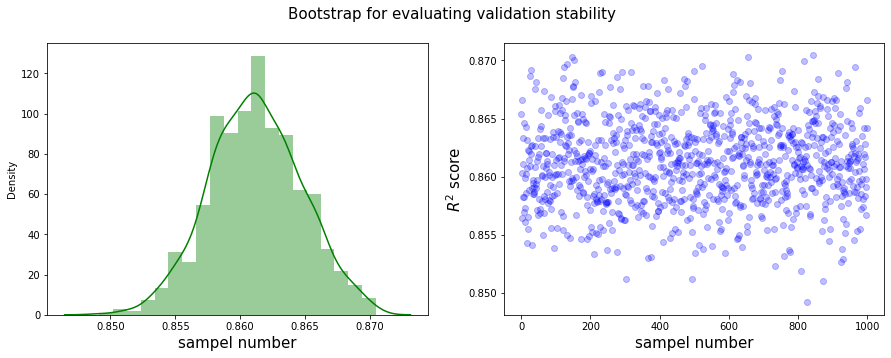

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
axes[1].scatter(range(len(scores)), scores, alpha=0.25, color="blue")
axes[1].set_xlabel("sampel number", size=15)
axes[1].set_ylabel("$R^2$ score", size=15)

sns.distplot(scores, ax=axes[0], color="green", bins=20)
axes[0].set_xlabel("sampel number", size=15)

**Вывод**

* Значение метрики на лидерборде (0.861) находится в пределах доверительного интервала от 0.854 до 0.868. 
* Hold-Out валидация с разбиением на 3 выборки является устойчивой.

## Задание 4: 
* выполнить **Adversarial Validation**, подобрать объекты из обучающей выборки, которые сильно похожи на объекты из **assignment_2_test.csv**, и использовать их в качестве валидационного набора.
* Оценить качество модели на ЛБ, сделать выводы о полученных результатах.

In [43]:
x_train = train[NUMERICAL_FEATS].copy()
x_lb = test[NUMERICAL_FEATS].copy()
y_train = train[TARGET].copy()

In [44]:
x_adv = pd.concat([
    x_train, x_lb], axis=0
)
y_adv = np.hstack((np.zeros(x_train.shape[0]), np.ones(x_lb.shape[0])))
assert x_adv.shape[0] == y_adv.shape[0]

In [45]:
%%time

model_adv = xgb.XGBClassifier(n_estimators=25)
model_adv.fit(x_adv, y_adv)

[12:20:39] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 42.5 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=25, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [46]:
y_pred_adv = model_adv.predict_proba(x_adv)
score = roc_auc_score(y_adv, y_pred_adv[:, 1])
print(round(score, 4))

0.894


In [48]:
pd.cut(
    y_pred_adv[:, 1], bins=np.arange(0, 1.01, 0.1)
).value_counts().sort_index()

(0.0, 0.1]    33168
(0.1, 0.2]    94159
(0.2, 0.3]    29462
(0.3, 0.4]    33410
(0.4, 0.5]    25165
(0.5, 0.6]    12985
(0.6, 0.7]     3295
(0.7, 0.8]     1672
(0.8, 0.9]     3019
(0.9, 1.0]    43666
dtype: int64

**Вывод**

* roc_auc_score = 0.894 (ближе к 1, чем к 0.5) . Модель классификации может отличить тестовую выборку от обучающей выборки, поэтому можно предполагать, что выборки имеют разные распределения. 

## Задание 5:
* сделать **KFold / StratifiedKFold валидацию** (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. 
* Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных; 
* Оценить качество на ЛБ, сделать выводы.

In [54]:
# X = X[NUMERICAL_FEATS]
# y = train[TARGET]

cv = cross_val_score(
    estimator=model_adv,
    X=X,
    y=y,
    scoring="roc_auc",
    cv=5
)

print(f"CV-results: {round(np.mean(cv), 4)} +/- {round(np.std(cv), 3)}")

[13:04:53] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:05:15] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:05:37] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:05:57] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation me

In [49]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        estimator.fit(x_train, y_train)
        y_train_pred = estimator.predict(x_train)
        y_valid_pred = estimator.predict(x_valid)

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [61]:
cv_strategy_cb = KFold(n_splits=5, random_state=None)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    X, y, estimator=model_cb_3, metric=roc_auc_score, cv_strategy=cv_strategy_cb
)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	total: 110ms	remaining: 18m 23s
100:	total: 11.7s	remaining: 19m 4s
200:	total: 23.9s	remaining: 19m 27s
300:	total: 36.3s	remaining: 19m 30s
400:	total: 48.1s	remaining: 19m 12s
500:	total: 59.4s	remaining: 18m 46s
600:	total: 1m 11s	remaining: 18m 41s
700:	total: 1m 23s	remaining: 18m 30s
800:	total: 1m 35s	remaining: 18m 16s
900:	total: 1m 47s	remaining: 18m
1000:	total: 1m 58s	remaining: 17m 49s
1100:	total: 2m 10s	remaining: 17m 36s
1200:	total: 2m 22s	remaining: 17m 23s
1300:	total: 2m 34s	remaining: 17m 12s
1400:	total: 2m 46s	remaining: 17m 1s
1500:	total: 2m 57s	remaining: 16m 44s
1600:	total: 3m 9s	remaining: 16m 33s
1700:	total: 3m 22s	remaining: 16m 27s
1800:	total: 3m 34s	remaining: 16m 17s
1900:	total: 3m 48s	remaining: 16m 11s
2000:	total: 3m 58s	remaining: 15m 55s
2100:	total: 4m 10s	remaining: 15m 40s
2200:	total: 4m 22s	remaining: 15m 28s
2300:	total: 4m 33s	remaining: 15m 16s
2400:	total: 4m 46s	remaining: 15m 5s
2500:	total: 4m 57s	remaining: 14m 51s
2600:	total:

300:	total: 36.9s	remaining: 19m 48s
400:	total: 49s	remaining: 19m 32s
500:	total: 1m	remaining: 19m 13s
600:	total: 1m 11s	remaining: 18m 44s
700:	total: 1m 22s	remaining: 18m 20s
800:	total: 1m 34s	remaining: 18m
900:	total: 1m 45s	remaining: 17m 45s
1000:	total: 1m 57s	remaining: 17m 32s
1100:	total: 2m 8s	remaining: 17m 16s
1200:	total: 2m 19s	remaining: 17m 2s
1300:	total: 2m 30s	remaining: 16m 49s
1400:	total: 2m 42s	remaining: 16m 37s
1500:	total: 2m 54s	remaining: 16m 28s
1600:	total: 3m 6s	remaining: 16m 16s
1700:	total: 3m 17s	remaining: 16m 3s
1800:	total: 3m 29s	remaining: 15m 53s
1900:	total: 3m 41s	remaining: 15m 41s
2000:	total: 3m 52s	remaining: 15m 30s
2100:	total: 4m 4s	remaining: 15m 20s
2200:	total: 4m 16s	remaining: 15m 9s
2300:	total: 4m 28s	remaining: 14m 58s
2400:	total: 4m 41s	remaining: 14m 49s
2500:	total: 4m 52s	remaining: 14m 37s
2600:	total: 5m 4s	remaining: 14m 25s
2700:	total: 5m 15s	remaining: 14m 12s
2800:	total: 5m 26s	remaining: 14m
2900:	total: 5m 

600:	total: 1m 10s	remaining: 18m 25s
700:	total: 1m 21s	remaining: 18m 2s
800:	total: 1m 32s	remaining: 17m 45s
900:	total: 1m 44s	remaining: 17m 31s
1000:	total: 1m 56s	remaining: 17m 25s
1100:	total: 2m 8s	remaining: 17m 17s
1200:	total: 2m 19s	remaining: 17m 3s
1300:	total: 2m 31s	remaining: 16m 53s
1400:	total: 2m 43s	remaining: 16m 41s
1500:	total: 2m 55s	remaining: 16m 32s
1600:	total: 3m 7s	remaining: 16m 21s
1700:	total: 3m 18s	remaining: 16m 9s
1800:	total: 3m 29s	remaining: 15m 53s
1900:	total: 3m 41s	remaining: 15m 43s
2000:	total: 3m 53s	remaining: 15m 31s
2100:	total: 4m 4s	remaining: 15m 20s
2200:	total: 4m 16s	remaining: 15m 9s
2300:	total: 4m 28s	remaining: 14m 59s
2400:	total: 4m 41s	remaining: 14m 49s
2500:	total: 4m 53s	remaining: 14m 39s
2600:	total: 5m 4s	remaining: 14m 25s
2700:	total: 5m 14s	remaining: 14m 11s
2800:	total: 5m 26s	remaining: 13m 58s
2900:	total: 5m 37s	remaining: 13m 44s
3000:	total: 5m 48s	remaining: 13m 32s
3100:	total: 6m	remaining: 13m 21s
32

**Вывод**
* Стандартное отклонение по фолдам на valid составляет 2.9% , сравнение среднего значения метрики на кросс-валидации теряет смысл, так как в подавляющем большинстве случаев средние будут отличаться менее чем на стандартное отклонение.

## Задание 6 (опциональное): 
* сделать Hold-Out валидацию по времени (TransactionDT), повторить процедуры из п.1 / п.2 (на ваш выбор). 
* Построить доверительный интервал, сравнить качество на ЛБ выборке с полученным доверительным интервалом. 
* Сделать выводы.

In [62]:
from sklearn.model_selection import TimeSeriesSplit

In [63]:
X = train[NUMERICAL_FEATS]
y = train[TARGET]

cv = TimeSeriesSplit()

for train_index, test_index in cv.split(X):
    X_train, X_valid = X.loc[train_index], X.loc[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    
X_train.shape,  X_valid.shape, y_train.shape, y_valid.shape

((150000, 377), (30000, 377), (150000,), (30000,))

In [64]:
%%time

model_cb_time = cb.CatBoostClassifier(**params_cb)
model_cb_time.fit(X=X_train, y=y_train, 
          eval_set=[(X_train, y_train), (X_valid, y_valid)],
         )

0:	test: 0.6295357	test1: 0.5987248	best: 0.5987248 (0)	total: 197ms	remaining: 32m 47s
100:	test: 0.8616417	test1: 0.8359972	best: 0.8409099 (69)	total: 14.6s	remaining: 23m 51s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8409099102
bestIteration = 69

Shrink model to first 70 iterations.
Wall time: 19.9 s


In [65]:
train_score = roc_auc_score(y_train, model_cb_time.predict_proba(X_train)[:, 1:])
valid_score = roc_auc_score(y_valid, model_cb_time.predict_proba(X_valid)[:, 1:])
lb_score = roc_auc_score(y_lb, model_cb_time.predict_proba(X_lb)[:, 1:])

print(f"Train-score: {round(train_score, 3)}, Valid-score: {round(valid_score, 3)}, LB-score: {round(lb_score, 3)}")

Train-score: 0.859, Valid-score: 0.841, LB-score: 0.838


In [66]:
scores = create_bootstrap_metrics(y_lb, model_cb_time.predict_proba(X_lb)[:, 1:], roc_auc_score)

calculate_confidence_interval(scores)

(0.830945921439085, 0.8447393719368593)

Text(0.5, 0, 'sampel number')

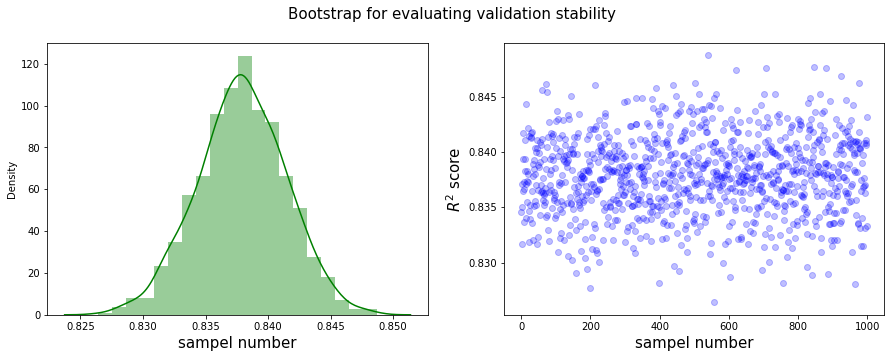

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
axes[1].scatter(range(len(scores)), scores, alpha=0.25, color="blue")
axes[1].set_xlabel("sampel number", size=15)
axes[1].set_ylabel("$R^2$ score", size=15)

sns.distplot(scores, ax=axes[0], color="green", bins=20)
axes[0].set_xlabel("sampel number", size=15)

**Вывод**

* Значение метрики на лидерборде (0.838) находится в пределах доверительного интервала от 0.831 до 0.845. 
* Значения метрики на обучающей (0.859), валидационной (0.841) выборках и лидерборде (0.838) сближены. 
* Валидация является устойчивой.



## Задание 7 (совсем опциональное): 
* в данном наборе данных у нас есть ID-транзакции (TransactionID) и время транзакции (TransactionDT), но отсутствует ID-клиента, который совершал транзакции. 
* Кажется, что в этой задаче валидация по клиенту работала бы хорошо. 
* Предложить критерий, по которому можно выделить клиентов и сделать п.5, используя созданное определение клиента, используя валидацию по клиенту (GroupKFold).